# Lab 3: Classification 


You will work with the crime data from Chicago's Open Data Portal to better understand the crimes that are reported in different neighborhoods in the city, whether those crimes result in arrest, and so forth. As in previous labs, you will acquite the data and familiarize yourself with its basic properties. You will then explore a few classification problems using different machine learning models.

You will also work towards building a modular machine learning pipeline that you can use for your class project and hopefully many other projects in the future. Finally, you will gain experience with geospatial data analysis.

## Learning Objectives

* Starting to build a reusable data science / machine learning analysis pipeline 
* Creating functions with fixed modules and steps that can be reused for your final project
* Writing several `scikit-learn` features by hand, like `GridSearchCV`
* Applying the following classification models (essentially plugging different functions into the same pipeline):
    * Logistic Regression
    * Naive Bayes
    * Support-Vector Machines

In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import censusdata

## Part 1: Data Acquisition and Exploratory Analysis

In the first part of the lab, you will acquire data from the Chicago Open Data Portal concerning crime statistics and perform basic exploration and analysis.

### 1.1 Data Download

Download [reported crime data for 2019](https://data.cityofchicago.org/Public-Safety/Crimes-2019/w98m-zvie) from the Chicago Open Data Portal. Your dataset should have roughly 260,000 observations. As always, think about what each row represents and familiarize yourself with the variables. 

In [3]:
df = pd.read_csv('Crimes_-_2019.csv')

### 1.2 Basic Exploratory Analysis

Before delving into our analysis, we want to explore the reported crime data. Your task here is to generate visualizations for each question, exploring the number of crimes of each type, how these change over time, and how they vary across neighborhoods. Note that this is intentionally open ended – produce visualizations that you think would be meaningful. 

Each of your visualizations should include a title, labeled axes, and a brief (2-3 sentence) description.

#### 1.2.1 How many crimes of each type are in these data? 

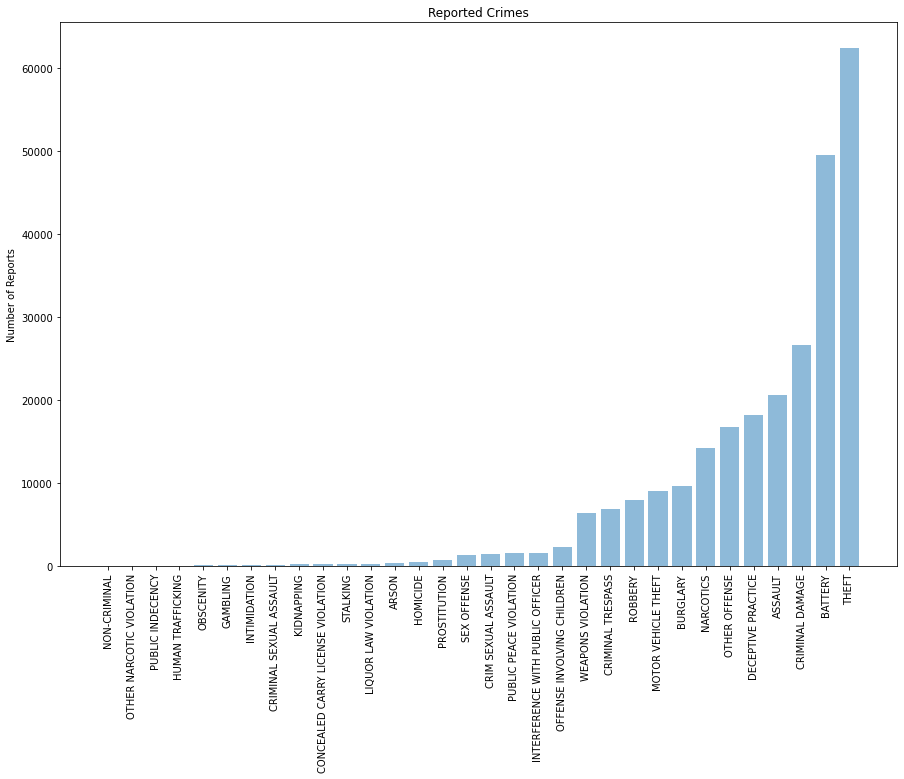

In [4]:
x = df.groupby('Primary Type')['ID'].count().reset_index().sort_values(by='ID')

plt.figure(figsize=(15,10))
plt.bar(range(len(x)), x['ID'], align='center', alpha=0.5)
plt.xticks(range(len(x)), x['Primary Type'], rotation=90)
plt.ylabel('Number of Reports')
plt.title('Reported Crimes')

plt.show()


Here, I just wanted to do a simple visualization of reports by type of crime.  It is meant to paint a broad portrait of the frequency of reports for each type of crime.

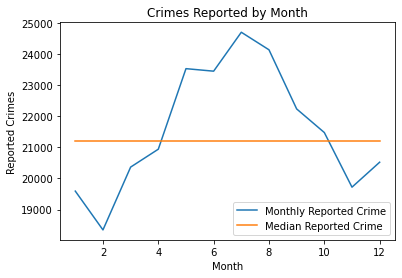

In [5]:
u = df.copy()
u['Date'] = pd.to_datetime(u['Date'])
u['Month'] = [i.month for i in u['Date']]
u = u.groupby('Month').count()['ID'].reset_index()
plt.plot(u['Month'], u['ID'], label='Monthly Reported Crime')
u['Median Reports'] = u['ID'].median()
plt.plot(u['Month'],u['Median Reports'], label='Median Reported Crime')
plt.xlabel('Month')
plt.ylabel('Reported Crimes')
plt.title('Crimes Reported by Month')
plt.legend()


Crime is broadly known to be subject to seasonality, so I wanted to visualize that for out dataset.  There are clear seasonality concerns in our data, which is consistent with expectations.  Crime that is likely to be reported to local police is often "weather-permitting".

#### 1.2.3 How did reported crimes vary across neighborhoods? 

You may find the [neighborhood boundaries data](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9) from the Chicago Data Portal and the `geopandas` [documentation on spatial joins](https://geopandas.org/mergingdata.html) useful here. A few more helpful resources can be found [here](https://gis.stackexchange.com/questions/174159/convert-a-pandas-dataframe-to-a-geodataframe) and [here](https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d).

Your data preparation process will likely include the following steps:
1. Load the neighborhood boundaries `geojson` file using `geopandas`.
2. Convert your crime dataframe to a `geopandas` dataframe.
3. Merge the crime `geopandas` dataframe and the neighborhoods `geopandas` dataframes.

In [6]:
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
geo_df = gpd.read_file('Boundaries - Neighborhoods.geojson')
crs = {'init': 'epsg:4326'}
df_points = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
crime_gdf = gpd.sjoin(df_points, geo_df, how="left", op='intersects')


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\geopandas\tools\sjoin.py:58: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 +type=crs != epsg:4326)
  warn(
C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


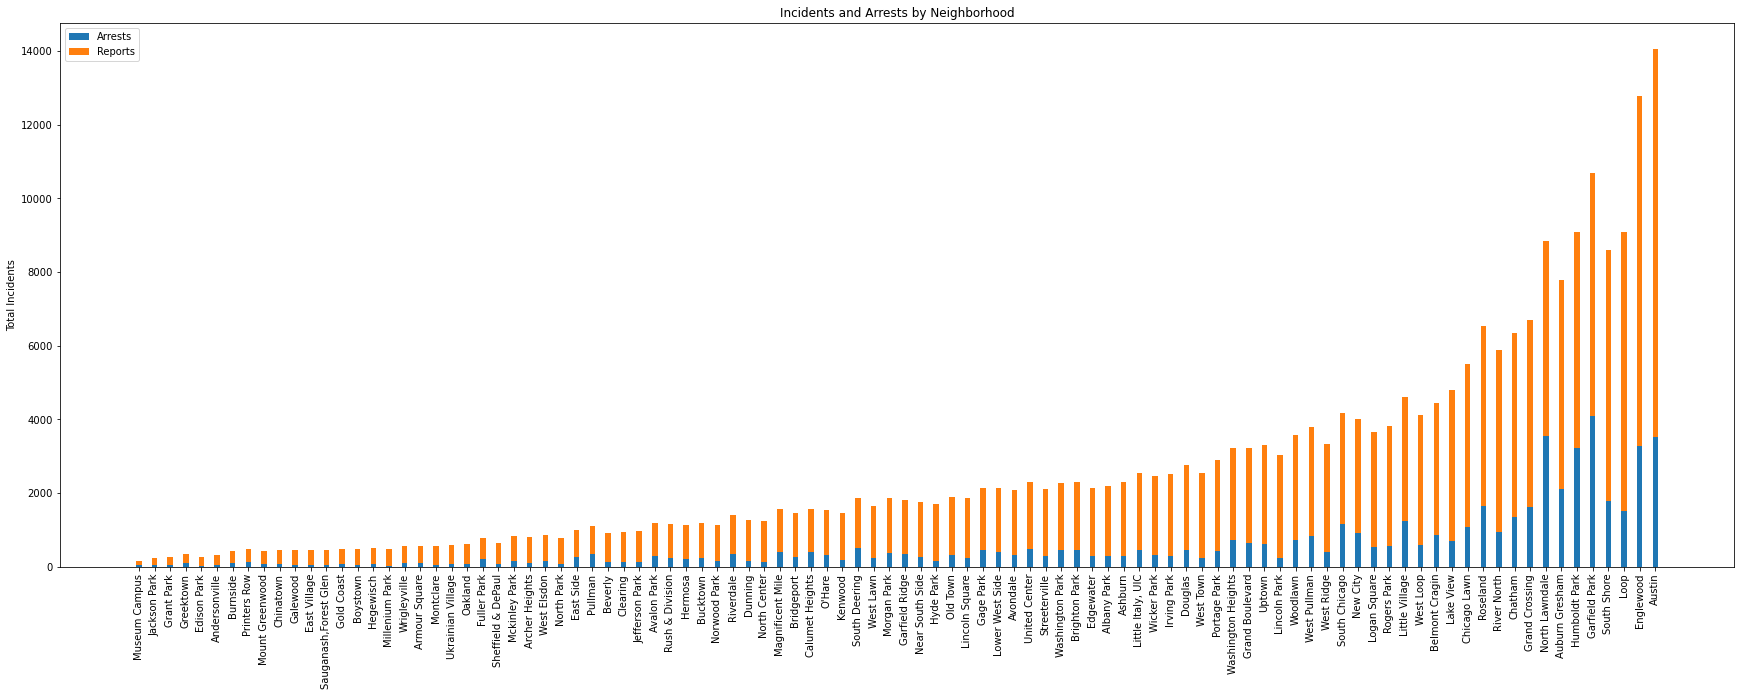

In [7]:
df_1 = crime_gdf.groupby('pri_neigh')['Arrest'].sum()
df_2 = crime_gdf[crime_gdf['Arrest']==False].groupby('pri_neigh').count()['ID']
df_full = pd.concat([df_1, df_2], axis=1).reset_index()
df_full = df_full.rename(columns={'ID':'Reports'}).sort_values(by='Reports')

labels = df_full.pri_neigh
men_means = df_full.Arrest
women_means = df_full.Reports
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(30,10))

ax.bar(labels, men_means, width, label='Arrests')
ax.bar(labels, women_means, width, bottom=men_means,
       label='Reports')
plt.xticks(range(len(labels)), labels, rotation=90)
ax.set_ylabel('Total Incidents')
ax.set_title('Incidents and Arrests by Neighborhood')
ax.legend()

plt.show()


The top of each orange bar represents the total number of reports in each bar and the top of each blue bar represents arrest.  This type of visualization is helpful because it allows the viewer to see both total numbers and a visualization of the proportion at the same time.  For example, crimes reported in North Lawndale lead to an arrest at a disproportionate rate.  Of course, a stacked bar chart can be nice to get some broad ideas and intuitions about proportions, but is not good for exactitude.

### 1.3 Joining with Census Data

The crime dataset includes lat/long fields, which can be joined with Census data. Your task now is to augment that data with [American Community Survey data](https://www.census.gov/programs-surveys/acs/data.html). For each crime report, use one of the census APIs to get additional data about the demographics of the block where the crime report came from. At a minimum, this should include the percentage of each block that is African American/Black (`Percent Black`) and White (`Percent White`), along with the median income in each block (`Median Income`). 

We recommend using [ACS 5-Year Data](https://www.census.gov/data/developers/data-sets/acs-5year.html), which is estimated for all geographies down to the block-group level. You may find the following resources helpful in constructing your API call: [ACS API Variable Formats](https://www.census.gov/data/developers/data-sets/acs-1year/notes-on-acs-api-variable-formats.html) and [Census Query Examples](https://www.census.gov/data/developers/guidance/api-user-guide/query-examples.html). The [Census Block TIGER boundaries](https://data.cityofchicago.org/dataset/CensusBlockTIGER2010/bt9m-d2mf/data) from the Chicago Data Portal may also be helpful in performing a spatial join between the ACS data and the crime data. 

#### Load ACS data, TIGER boundaries, and merge to crime data


1. Load the ACS data with at least variables for `Total Population`, `White`, `Black`, and `Median Income`.
2. Load the TIGER neighborhood boundaries `geopandas` dataframe.
3. Merge the ACS dataframe and the TIGER `geopandas` dataframe. The result will be a `geopandas` dataframe.
4. Merge the ACS `geopandas` dataframe that you created in step 3 with your crime `geopandas` dataframe from section above.
5. Compute the percentage of each Census block's population that is White and African American/Black.

Based on this augmented data, explore the characteristics of blocks with crime reports. For instance, you might look into demographic trends as they relate to homicides or total reported crimes. Provide descriptive statistics and produce at least one visualization. Again, include a title, labeled axes, and a brief description.

In [10]:
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
acs_data = censusdata.download("acs5", 2015, censusdata.censusgeo(
    [("state", "17"), ("county", "031"), ("block group", "*")]),
    ["B02001_001E","B02001_002E", "B02001_003E", "B19013_001E", "GEO_ID"])
#get fips
census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
acs_data["geo_12"] = acs_data["GEO_ID"].map(lambda x: str(x)[-12:])
#merge on fips
merged_gdf = (gpd.GeoDataFrame(acs_data.merge(census_gdf, on="geo_12", how="inner"), 
                               crs=crime_gdf.crs))
gdf = gpd.sjoin(crime_gdf.drop(['index_right'], axis='columns'), merged_gdf, how="left", op='intersects')

C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [11]:
gdf.rename(columns = {'B02001_001E': 'total_population', 
                      'B02001_002E': 'white',
                      'B02001_003E': 'black',
                      'B19013_001E': 'median_income'}, inplace = True) 
gdf['percent_white'] = gdf['white']/gdf['total_population']
gdf['percent_black'] = gdf['black']/gdf['total_population']
gdf.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'geometry', 'pri_neigh', 'sec_neigh', 'shape_area',
       'shape_len', 'index_right', 'total_population', 'white', 'black',
       'median_income', 'GEO_ID', 'geo_12', 'statefp10', 'name10', 'blockce10',
       'tract_bloc', 'geoid10', 'tractce10', 'countyfp10', 'percent_white',
       'percent_black'],
      dtype='object')

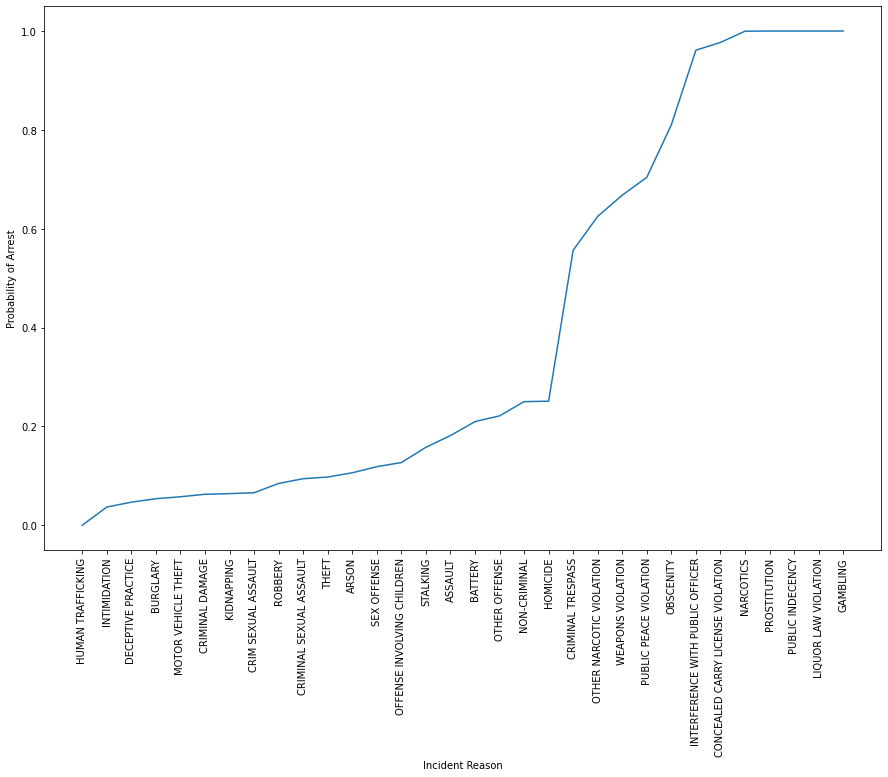

In [12]:
inter_prob = (gdf.groupby('Primary Type').sum()['Arrest']/gdf.groupby('Primary Type').count()['ID']).reset_index()
prob_df = inter_prob.rename(columns={0:'Probability'}).sort_values(by='Probability')

plt.figure(figsize=(15,10))
plt.plot(prob_df['Primary Type'], prob_df['Probability'])
plt.xticks(rotation=90)
plt.xlabel('Incident Reason')
plt.ylabel('Probability of Arrest')
plt.show()

I think knowing the probability of an arrest given a report of a specific type of crime is important context for us as we proceed to create and evaluate our predictive models.  It would be interesting to know how many arrests were the result of civilian reports.  For example, Liquor Law Violation and gambling have a 100% arrest rate. It could be worth, in another context, investigating whether it was simply an offense written up by an officer upon sight (rather than a civilian report), which could raise equity concerns because it relies entirely on officer discretion.

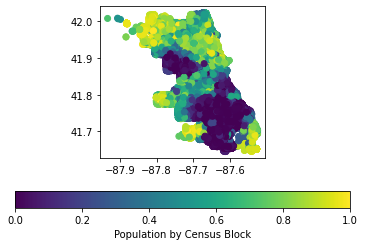

In [13]:
fig, ax = plt.subplots(1, 1)

gdf.plot(column='percent_white', ax=ax, legend=True,
            legend_kwds={'label': "Population by Census Block",
                         'orientation': "horizontal"})

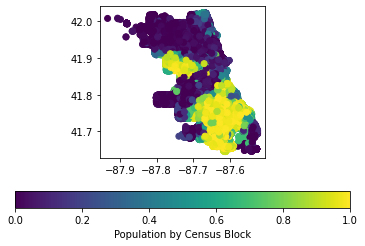

In [14]:
fig, ax = plt.subplots(1, 1)

gdf.plot(column='percent_black', ax=ax, legend=True,
            legend_kwds={'label': "Population by Census Block",
                         'orientation': "horizontal"})

Here, we see that there is little overlap between white and black people in most Chicago neighborhoods.  This would be interesting to come back to after building our classifiers.

### 1.4 Basic Bayesian Probability

Assume you are running the 911 call center for Chicago. You get a call from someone at 5801 S Ellis Ave.  In this section, we ask several basic questions. Produce your answers by writing code against the dataframes above.

You are also welcome to express your answer mathematically. You can use LaTeX syntax in notebooks to write equations.

**1.4.1. Which crime type is the most likely given the call came from 5801 S Ellis Ave? (What are the probabilities for each type of crime?)**

In [23]:
def get_prob(df, filter_val, filter_col, targ_col):
    new_df = gdf[gdf[filter_col] == filter_val]
    prob_dict = {}
    for i in new_df[targ_col].unique():
        prob_dict[i] = prob_dict.get(i, 0) + new_df[new_df[targ_col] == i].count()[0]/len(new_df)
    rv = pd.DataFrame.from_dict(prob_dict,orient='index', columns=['probability'])
    rv.index.name = targ_col
    return rv.sort_values(by='probability', ascending=False)
get_prob(gdf, 41.0, 'Community Area', 'Primary Type')


,probability
Primary Type,
THEFT,0.350204
BATTERY,0.147760
DECEPTIVE PRACTICE,0.105294
CRIMINAL DAMAGE,0.079116
ASSAULT,0.072717
OTHER OFFENSE,0.065736
ROBBERY,0.041885
MOTOR VEHICLE THEFT,0.037231
BURGLARY,0.031995


**1.4.2. Let’s now assume that a call comes in about Theft. Which is more likely – that the call came from Logan Square or Hyde Park? How much more or less likely is it to be from Logan Square vs. Hyde Park?**

You can consult [this link](https://en.wikipedia.org/wiki/Community_areas_in_Chicago) to see a list of community areas and their numbers, which corresponds to the `Community Area` field in the crime dataframe.

In [33]:
probs = get_prob(gdf, 'THEFT', 'Primary Type', 'Community Area')
hyde_park = 41 # community ids
logan_square = 22
hyde_park_prob = probs[probs.index==hyde_park].probability.values[0]
logan_square_prob = probs[probs.index==logan_square].probability.values[0]
if logan_square_prob > hyde_park_prob:
    print('Logan Square is {} times more likely than Hyde Park'.format(logan_square_prob/hyde_park_prob))
else:
    print('Hyde Park is {} times more likely than Logan Square'.format(hyde_park_prob/logan_square_prob))


Logan Square is 3.0265780730897007 times more likely than Hyde Park


I know the method above is not the most efficient, but people are often confused by bayesian probability and I wanted to focus on making the process clear and easy to follow

**1.4.3. Now assume that you don’t have access to all the raw data and you know the following facts:**

* There are a total of 2000 calls, 800 from Garfield Park and 500 from Uptown. 
* Of the 800 calls from Garfield Park, 200 of them are about Battery. 
* Of the 500 calls from Uptown, 160 are about Battery. 

If a call comes about Battery, how much more/less likely is it that the call came from Garfield Park versus Uptown?

In [34]:
#stayin bayesian
gp = 200/360
up = 160/360
'It is {} times more likely'.format(gp / up)

'It is 1.2500000000000002 times more likely'

---

## Part 2: Machine Learning Pipeline

When working on supervised machine learning projects, you will find yourself repeatedly performing tasks with slight variations. This naturally lends itself to a pipeline – or a set of functions that can help automate your workflow. The goal of this section is to start to build a simple, modular, and extensible pipeline, and then to apply this pipeline to the classification problem described above (i.e. predicting whether an arrest occured).

**Do NOT use `sklearn.pipeline.Pipeline()` here**. An important objective of this assignment is to understand how this process works and the ways different steps can be customized when designed from scratch.

You may find it useful to read through Part 2 in its entirety before beginning. You will use the code you write for your pipeline in Part 2.1 to answer the questions in Part 2.2.

### 2.1 Building the Pipeline 

To reiterate, the objective here is to build a simple and modular pipeline that can be extended throughout the quarter. Your framework should include the components described below, but is likely to evolve as you begin applying it to different machine learning tasks. Your functions should be well-documented and appropriately named. Focus on the structure, modularity, and extensibility. 

Your functions should be written in a separate `pipeline.py` file that you import into this (and future) notebooks. At a minimum, include the following components – 

1. **Read Data**  
2. **Explore Data**  
3. **Create Training and Testing Sets**  
4. **Pre-Process Data**  
5. **Generate Features**   
6. **Build Classifiers**   
7. **Evaluate Classifiers**  

Import your pipeline into this notebook in the cell below. 

In [35]:
import pipeline as pipeline 

### 2.2 Applying the Pipeline 

Your task is to build a classifier that predicts the binary outcome of whether an arrest occured in each report (`Arrest`). Your classifier should take the following features as inputs: 
- `Primary Type` 
- `Ward` 
- `FBI Code`
- `Percent White` 
- `Percent Black`
- `Median Income`

Note that the three features from the crime data (`Primary Type`, `Ward`, and `FBI Code`) are categorical, while the three features from the ACS data (`Percent White`, `Percent Black`, and `Median Income`) are continuous. 

Train and evaluate the following types of classifiers: 
- Logistic Regression (`sklearn.linear_model.LogisticRegression`) 
- Support Vector Machines (`sklearn.svm.LinearSVC`)
- Naive Bayes (`sklearn.naive_bayes.GaussianNB`)

Use the helper functions that you wrote in your `pipeline.py` file to work through this classification task. The majority of the work in each cell should be performed by your `pipeline.py` functions, but you can add some extra code in this notebook if need be.

#### 2.2.1 Read Data (Call from Part 1)
We will be using the dataset compiled in Step 1. Feel free to drop any extra columns that you may have acquired in merging datasets above, and print out the first few rows of this dataset. 

In [49]:
crimes = gdf[['Primary Type', 'Ward', 'FBI Code', 'percent_white', 'percent_black', 'median_income', 'Arrest']]
crimes.head()

,Primary Type,Ward,FBI Code,percent_white,percent_black,median_income,Arrest
0,OTHER OFFENSE,41.0,26,NaN,NaN,NaN,False
1,DECEPTIVE PRACTICE,31.0,11,NaN,NaN,NaN,False
2,WEAPONS VIOLATION,10.0,15,0.381182,0.514475,28349.0,True
3,ASSAULT,18.0,04A,0.592437,0.159664,51313.0,False
4,BATTERY,15.0,04B,0.662278,0.031899,39138.0,False


#### 2.2.2 Explore Data
Apply one of the exploration functions in your pipeline on this dataset. 

,Ward,percent_white,percent_black,median_income
count,259031.000000,255795.000000,255795.000000,2.475440e+05
mean,23.326308,0.337394,0.513784,-4.490952e+06
std,13.917489,0.338081,0.424769,5.481900e+07
min,1.000000,0.000000,0.000000,-6.666667e+08
25%,10.000000,0.012034,0.046441,2.551500e+04
50%,24.000000,0.192032,0.558394,3.666700e+04
75%,34.000000,0.647252,0.956661,6.068200e+04
max,50.000000,1.000000,1.000000,1.896880e+05


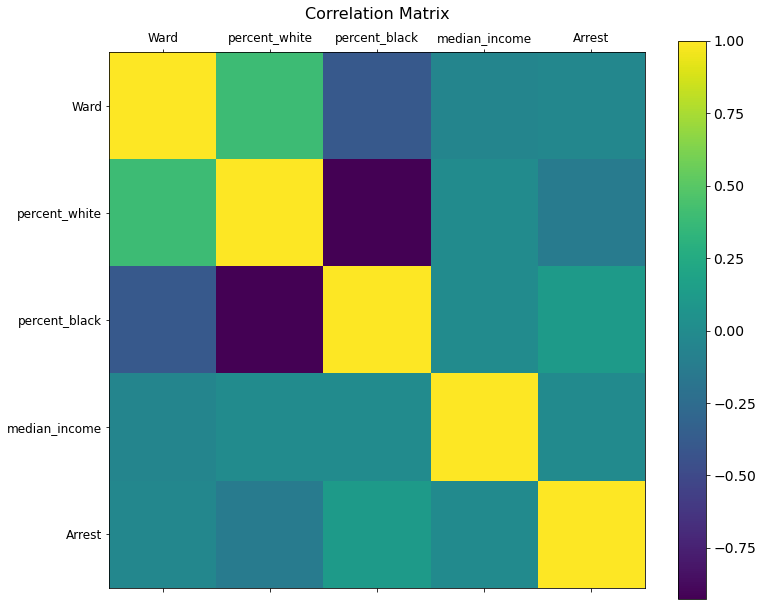

In [37]:
pipeline.describe_columns(crimes)

#### 2.2.3 Create Training and Testing Sets
Recall that all pre-processing steps must be done separately on your training and testing data. As a result, you should split your data into training and testing sets at the onset. Print out the number of observations in your training and testing sets. 

In [38]:
train_df, test_df = pipeline.train_test(crimes, 0.2, 42)

#### 2.2.4 Pre-Process Data & Generate Features

We will do these steps separately for the label, the numeric features, and the categorical features.  

First, convert the label `Arrest` into a numerical (rather than boolean) feature in both your training and testing data. Print the percentage of recorded crimes in your training data that resulted in an arrest. 

In [39]:
train_df['Arrest'] = pipeline.boolean_to_numeric(train_df, 'Arrest')
test_df['Arrest'] = pipeline.boolean_to_numeric(test_df, 'Arrest')
    

<ipython-input-39-69010bc99529>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Arrest'] = pipeline.boolean_to_numeric(train_df, 'Arrest')
<ipython-input-39-69010bc99529>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Arrest'] = pipeline.boolean_to_numeric(test_df, 'Arrest')


Next, pre-process the continuous numeric features (`Percent White`, `Percent Black`, `Median Income`). This should include the following steps: 
1. Impute missing values. Here, feel free to simply use the mean or the median of the column. 
2. Normalize each feature to have a mean of zero and standard deviation of one. Recall that this should be done based on the training data. 

Note that administrative data often uses encodings to indicate missing data. Always be sure to perform sanity checks (e.g. ensure that your percentages fall between 0 and 1, that income follows a reasonable distribution, etc.) 

In [40]:
train_df = pipeline.impute_values(train_df, ['percent_white', 'percent_black', 'median_income'])
test_df = pipeline.impute_values(test_df, ['percent_white', 'percent_black', 'median_income'])
train_df, test_df = pipeline.normalize(['percent_white', 'percent_black', 'median_income'], train_df, test_df)

Finally, encode features from the categorical variables (`Primary Type`, `Ward`, and `FBI Code`).  

An inherent issue arises with this approach when a value appears in either your training or testing data, but not in both. Ensure your pipeline can handle this defensibly. 

In [41]:
train_final, test_final = pipeline.encode_categoricals(train_df, test_df, ['Primary Type', 'Ward', 'FBI Code'])

We now have a modeling dataset that we can use to train and evaluate classifiers. Print out the first few rows of your training dataset. At this point, your dataset should only include the features created above and the label `Arrest`. 

In [42]:
train_final.head()

,Arrest,percent_white,percent_black,median_income,Primary Type__ARSON,Primary Type__ASSAULT,Primary Type__BATTERY,Primary Type__BURGLARY,Primary Type__CONCEALED CARRY LICENSE VIOLATION,Primary Type__CRIM SEXUAL ASSAULT,...,FBI Code__14,FBI Code__15,FBI Code__16,FBI Code__17,FBI Code__18,FBI Code__19,FBI Code__20,FBI Code__22,FBI Code__24,FBI Code__26
32462,0,-0.884526,1.015481,0.080937,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3950,0,1.079589,-1.218393,0.081212,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111765,0,-0.998157,0.975000,0.081465,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
45324,0,-0.790552,0.928341,0.081051,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185190,0,-0.458878,0.260039,0.081048,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Create a sanity check to make sure your pipeline works

In [43]:
def sanity_check(train_df, test_df): 
    
    # Sort features alphabetically
    train_df = train_df.reindex(sorted(train_df.columns), axis=1)
    test_df = test_df.reindex(sorted(test_df.columns), axis=1)

    # Check that they have the same features
    if (train_df.columns == test_df.columns).all():
        print("Success: Features match")

    # Check that no NAs remain
    if  not train_df.isna().sum().astype(bool).any() and \
        not test_df.isna().sum().astype(bool).any():
        print("Success: No NAs remain")
        
sanity_check(train_final, test_final)

Success: Features match
Success: No NAs remain


#### 2.2.5 Build and Evaluate Classifiers  

Train and evaluate models using the following types of classifiers and hyperparameters set to several values:
- Logistic Regression (`sklearn.linear_model.LogisticRegression`): `penalty`, `C`  
- Support Vector Machines (`sklearn.svm.LinearSVC`): `C`
- Naive Bayes (`sklearn.naive_bayes.GaussianNB`)

In [44]:
results = pipeline.make_models(train_final, test_final, 'Arrest')

Training model: LogisticRegression | {'penalty': 'l2', 'C': 0.01, 'random_state': 0}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 0.1, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training model: LogisticRegression | {'penalty': 'l2', 'C': 1, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training model: LogisticRegression | {'penalty': 'l2', 'C': 10, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training model: LogisticRegression | {'penalty': 'l2', 'C': 100, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:1318: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 0.01, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:1318: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 0.1, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training model: LogisticRegression | {'penalty': 'none', 'C': 1, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:1318: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:1318: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training model: LinearSVC | {'C': 0.01, 'random_state': 0}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0}
Training model: LinearSVC | {'C': 1, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training model: LinearSVC | {'C': 10, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training model: LinearSVC | {'C': 100, 'random_state': 0}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training model: GaussianNB | {'priors': None}
Time Elapsed: 0:03:40.604834


### 2.3 Summarizing the Classification Models

#### 2.3.1. Summarize performance across your models. 
Produce a table summarizing each of your model specifications. Your columns should include the type of classifier (i.e. Logistic Regression, SVM, or Naive Bayes), the parameters for that iteration (e.g. `{'C': 0.1, 'penalty': 'l1'}`), and the evalaution metrics that you selected. Recall that this table should include 16 rows – or one for each model specification. 

In [45]:
results

,accuracy,f1,model,parameters,precision,recall
0,0.871627,0.607124,LogisticRegression,"{'penalty': 'l2', 'C': 0.01, 'random_state': 0}",0.844675,0.473859
1,0.871878,0.608470,LogisticRegression,"{'penalty': 'l2', 'C': 0.1, 'random_state': 0}",0.844328,0.475611
2,0.871762,0.608347,LogisticRegression,"{'penalty': 'l2', 'C': 1, 'random_state': 0}",0.843275,0.475795
3,0.871666,0.608445,LogisticRegression,"{'penalty': 'l2', 'C': 10, 'random_state': 0}",0.841917,0.476349
4,0.871646,0.608132,LogisticRegression,"{'penalty': 'l2', 'C': 100, 'random_state': 0}",0.842449,0.475795
5,0.871762,0.608301,LogisticRegression,"{'penalty': 'none', 'C': 0.01, 'random_state': 0}",0.843387,0.475703
6,0.871762,0.608301,LogisticRegression,"{'penalty': 'none', 'C': 0.1, 'random_state': 0}",0.843387,0.475703
7,0.871762,0.608301,LogisticRegression,"{'penalty': 'none', 'C': 1, 'random_state': 0}",0.843387,0.475703
8,0.871762,0.608301,LogisticRegression,"{'penalty': 'none', 'C': 10, 'random_state': 0}",0.843387,0.475703
9,0.871762,0.608301,LogisticRegression,"{'penalty': 'none', 'C': 100, 'random_state': 0}",0.843387,0.475703


#### 2.3.2 Describe the best performing model. 

Based on the table above, what type of classifier performed best and with which set of hyperparameters? 

Given our purpose, I believe accuracy is the best way to measure our models.  By that measure, our best model is a logistic regression, with a regularization parameter of 0.1 and a ridge regression method for penalization.  We have fairly strong regularization, so it is likely that our other models are overfitting and thus not performing well on the testing data.

#### 2.3.3 Which features were most important in the best performing model? 

In [47]:
from sklearn.linear_model import LogisticRegression
X_train = train_final.drop(columns=['Arrest'])
y_train = train_final['Arrest']
model = LogisticRegression()
model.set_params(**{'penalty': 'l2', 'C': 0.1, 'random_state': 0})
model.fit(X_train, y_train)

feature_names = list(X_train.columns)
smallest_included = 0
features_coef={feature_names[k]:v for k,v in enumerate(model.coef_[0])}


C:\Users\ryanw\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
top_features = []
top_ten = sorted(model.coef_[0], key=abs)[-10:]
for k, v in features_coef.items():
    if v in top_ten:
        top_features.append((k,v))
top_features
    

[('Primary Type__INTERFERENCE WITH PUBLIC OFFICER', 1.7185716103578275),
 ('Primary Type__KIDNAPPING', -1.4918088851175282),
 ('Primary Type__LIQUOR LAW VIOLATION', 1.537127090914203),
 ('Primary Type__NARCOTICS', 3.293453534270436),
 ('Primary Type__PROSTITUTION', 1.9405110503547363),
 ('FBI Code__08A', -1.8131992250734164),
 ('FBI Code__16', 1.9405110503547363),
 ('FBI Code__18', 3.0934125983012426),
 ('FBI Code__22', 1.537127090914203),
 ('FBI Code__24', 1.769676027711748)]

#### 2.3.4 Briefly describe your findings for a non-technical audience.  
Describe the machine learning question you addressed, the methods your used, and your results. Discuss the broader policy implications of your analysis and any relevant caveats. Limit your response to 5-7 sentences. 

We set out to classify whether a reported crime would lead to an arrest.  We use a tool called a logistic regression, which predicts a binary outcome (yes/no or true/false, for example) based on some set of criteria.  While the dependent variable (outcome) we are predicting must be binary, our independent variables (predictors) can include a variety of types.  We were able to predict whether a report resulted in an arrest with 87% accuracy, and the most important predictor of arrest was whether the reported crime was narcotics related.  Our tool is meant to classify an outcome and not to make causal inferences, but it is worth noting that our most important feature is whether the crime report was narcotics related and that liquor law violations is an important feature, which is generally considered a very minor "quality of life" offense.  Were we to delve deeper and investage causal concerns, I think framing our question around narcotics and quality of life offenses would be important to scope.